In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../'

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent


In [2]:
# https://laurentperrinet.github.io/sciblog/posts/2020-08-09-nesting-jupyter-runs.html
    
#verb =  (__name__ == "__main__")
def has_parent():
    """
    https://stackoverflow.com/questions/48067529/ipython-run-magic-n-switch-not-working
    
    Return True if this notebook is being run by calling
    %run in another notebook, False otherwise.
    """
    try:
        __file__
        # __file__ has been defined, so this notebook is 
        # being run in a parent notebook
        return True

    except NameError:
        # __file__ has not been defined, so this notebook is 
        # not being run in a parent notebook
        return False
def do_verb():
    return not has_parent()


do_it = do_verb()
if do_it : print(' Running this notebook directly = ', do_it)    


 Running this notebook directly =  True


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
# 
# https://en.wikipedia.org/wiki/ISO_8601
import datetime
timestr = datetime.datetime.now().date().isoformat()
timestr = '20201021'
timestr = '2020-11-03'
tau = 9e-4

from HOTS.Event import conv2eve
from HOTS.Tools import SaveObject, LoadObject

ds = 10
ds = 1
NbClusteringData = 2500//ds
NbTrainingData = 5000//ds
NbTestingData = 1500//ds

In [4]:
def get_nmnist(timestr, NbTrainingData, NbTestingData, NbClusteringData, DataPath='Data/testsetnmnist.p', verbose=False):
    fname_event_nmnist = f'Records/EXP_03_NMNIST/{timestr}_hots_event_nmnist.pkl'
    # print(help(LoadNMNIST))
    try:
        dataset = LoadObject(fname_event_nmnist)
        if verbose: print('loading the events from file', fname_event_nmnist)
    except:
        from HOTS.Event import LoadNMNIST
        dataset = LoadNMNIST(NbTrainingData, NbTestingData, NbClusteringData, 
                             Path=DataPath, verbose=0)
        SaveObject(dataset, fname_event_nmnist)
        if verbose: print('saving the events to file', fname_event_nmnist)

    events_train, events_test, event_cluster, labels_train, labels_test = dataset
    return events_train, events_test, event_cluster, labels_train, labels_test


In [5]:
def get_events(timestr, NbTrainingData=NbTrainingData, NbTestingData=NbTestingData, NbClusteringData=NbClusteringData, 
               tau=tau, # -> tau=1ms, si on prend 10 ms on est à 1s pour la dernière couche et les vidéos font 0.3s en moyenne
               homeo=True, verbose=False):
    R = 2    
    filthr = 2
    nbkNN = 3
    algo = 'lagorce'
    decay = 'exponential'
    krnlinit = 'rdn'
    nb_cluster = [4, 8, 16]

    fname_ = f'Records/EXP_03_NMNIST/{timestr}_hots_{tau*1000}'
        
    label = '_homeo' if homeo else ''
    
    fname_model = fname_ + 'ms_' + algo + label + '.pkl'
    fname_event0_o = fname_ + '_event_o' + algo + label + '.pkl'

    if not os.path.isfile(fname_event0_o):            
        if verbose: print('creating the events in file', fname_event0_o)
        from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
        from HOTS.Event import Event, SimpleAlphabet, LoadNMNIST
        from HOTS.STS import STS
        from HOTS.Layer import ClusteringLayer
        from HOTS.ToolsMonitor import (
            DisplayImage,
            DisplaySurface3D,
            DisplaySurface2D,
            DisplayConvergence,
        )
        from HOTS.Network import Network
        from HOTS.Event import conv2eve

        events_train, events_test, event_cluster, labels_train, labels_test = get_nmnist(timestr, NbTrainingData, NbTestingData, NbClusteringData)
        
        L1 = ClusteringLayer(tau=tau,R=R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=homeo,init=krnlinit)
        L2 = ClusteringLayer(tau=10 * tau,R=2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=homeo,init=krnlinit)
        L3 = ClusteringLayer(tau=10 * 10 * tau,R=2 * 2 * R,verbose=0,ThrFilter=filthr,LearningAlgo=algo,kernel=decay,homeo=homeo,init=krnlinit)
        Net = Network([L1, L2, L3])    


        if not os.path.isfile(fname_model):
            ClusterLayer, event_output = Net.TrainCluster(
                    event=event_cluster, NbClusterList=nb_cluster, to_record=True, NbCycle=1
                )
            SaveObject(ClusterLayer, fname_model)
        else: 
            if verbose: print('loading model from file', fname_model)

            ClusterLayer, Classif0 = LoadObject(fname_model)

        if verbose: print('run the events through the network')
        homrun = False
        events_train_o = Net.RunNetwork(events_train, NbClusterList=ClusterLayer, homrun=homrun)
        events_test_o = Net.RunNetwork(events_test, NbClusterList=ClusterLayer, homrun=homrun)
        SaveObject([events_train, events_test], fname_event0_o)
    else: 
        if verbose: print('loading the events from file', fname_event0_o)
        events_train_o, events_test_o = LoadObject(fname_event0_o)
        
    return events_train_o, events_test_o


### Building matrix for logistic regression

In [6]:
def gather_data(events_in, labels_in, 
                tau_cla=.150, # characteristic time of a digit 
                sample_events=200, sample_space = 1,
                verbose=False, debug=False):
    
    c_int = lambda n, d : ((n - 1) // d) + 1

    n_events = events_in.time.shape[0]

    data = np.zeros((c_int(events_in.ImageSize[0], sample_space), 
                     c_int(events_in.ImageSize[1], sample_space), 
                     len(events_in.ListPolarities))) #tmp data

    X = np.zeros((c_int(n_events, sample_events), len(data.ravel())))
    y = np.zeros((c_int(n_events, sample_events), ))

    #t_absolute = 0
    #t_old = 0
    #i_labels = 0
    for i_event in range(1, n_events):
        #if i == events_in.ChangeIdx[i_labels]:
            #i_labels += 1
            #t_absolute += events_in.time[i]
        #t_new = t_absolute + events_in.time[i]
        #t_new = events_in.time[i]
        
        d = np.exp(-(events_in.time[i_event]-events_in.time[i_event-1])/tau_cla)
        data *= d 
        if debug: assert(d <= 1) # is inferior to 1
        
        #t_old = t_new

        x_pos = events_in.address[i_event, 0]//sample_space
        y_pos = events_in.address[i_event, 1]//sample_space
        p = events_in.polarity[i_event]
        data[x_pos, y_pos, p] = 1.

        if i_event % sample_events == sample_events//2 :
            if debug: 
                print(f'DEBUG {i_event=} {i_event//sample_events=} ')
                print(f'DEBUG {y[i_event//sample_events]=}   ')
                print(f'DEBUG  {labels_in[i_event]=} ')
            X[i_event//sample_events, :] = data.ravel()
            y[i_event//sample_events] = labels_in[i_event]
            

    if verbose: print('Number of events: ' + str(X.shape[0])+' - Number of features: ' + str(X.shape[1]))

    return X, y


In [7]:
from sklearn.linear_model import LogisticRegression as LR
# from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.model_selection import train_test_split

opts_LR = dict(random_state=0, max_iter=5000, n_jobs=-1, class_weight='balanced')
#opts_LR['Cs'] = 5
#opts_LR['Cs'] = 32


In [8]:
if do_it : 
    tic = time.time()
    dataset = get_nmnist(timestr, NbTrainingData, NbTestingData, NbClusteringData, verbose=True)
    events_train, events_test, events_cluster, labels_train, labels_test = dataset
    print(f'Done in {time.time() - tic:.3f}')
    print(events_train.ListPolarities)

loading the events from file Records/EXP_03_NMNIST/2020-11-03_hots_event_nmnist.pkl
Done in 0.705
[0 1]


In [9]:
np.unique(labels_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

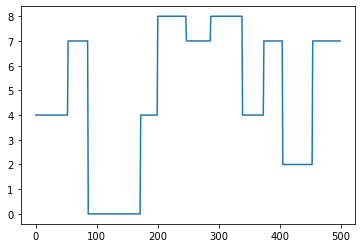

In [10]:
plt.plot(labels_train[:50000:100])

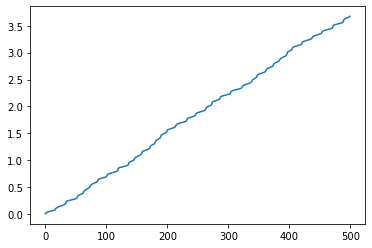

In [11]:
plt.plot(events_train.time[:50000:100])

In [12]:
np.unique(labels_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

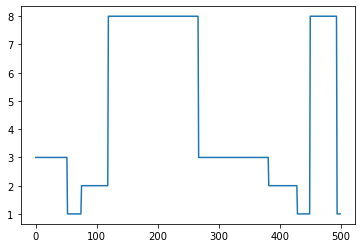

In [13]:
plt.plot(labels_test[:50000:100])

In [14]:
c_int = lambda n, d : ((n - 1) // d) + 1
sample_events=100
n_events = events_train.time.shape[0]
y = np.zeros((c_int(n_events, sample_events), ))
n_events, y.shape

(20951770, (209518,))

In [15]:
from joblib import parallel_backend


In [16]:
if do_it : 
    opts_LR = dict(random_state=0, max_iter=500, n_jobs=10, class_weight='balanced')
    opt_gather = dict(sample_events=100, sample_space = 4, verbose=True)

    tic = time.time()
    X_train, y_train = gather_data(events_train, labels_train,  **opt_gather)
    print(f'Done in {time.time() - tic:.3f}')

Number of events: 209518 - Number of features: 162
Done in 126.879


In [17]:
if do_it : 
    tic = time.time()
    with parallel_backend('loky'):
        lr = LR(**opts_LR).fit(X_train, y_train)
    print(f'Classification score for raw input is {lr.score(X_train, y_train):.3f}')
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    X_test, y_test = gather_data(events_test, labels_test,  **opt_gather)
    print(f'Classification score for raw input is {lr.score(X_test, y_test):.3f}')
    print(f'Done in {time.time() - tic:.3f}')
    

Classification score for raw input is 0.681
Done in 254.382
Number of events: 63381 - Number of features: 162
Classification score for raw input is 0.646
Done in 39.606


In [18]:
y_train[:100]

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
np.unique(y_train)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [20]:
y_pred = lr.predict(X_test)

In [21]:
np.unique(y_train), np.unique(y_test), np.unique(y_pred)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]))

In [22]:
import pickle
EVE = pickle.load(open('Data/testsetnmnist.p', "rb" ))

In [23]:
len(EVE)

10000

In [24]:
e0 = EVE[0]

In [25]:
e0.l, e0.t

(0, array([   581,   1703,   2625, ..., 307025, 307397, 308529], dtype=int32))

In [26]:
labels = []
for e_i in EVE:
    labels.append(e_i.l)
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

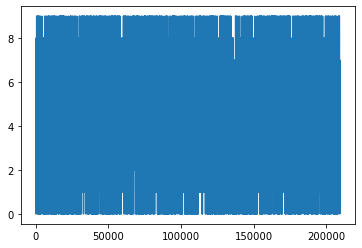

In [27]:
plt.plot(y_train)

In [28]:
import random

In [29]:
random.sample?

Signature: random.sample(population, k)
Docstring:
Chooses k unique random elements from a population sequence or set.

Returns a new list containing elements from the population while
leaving the original population unchanged.  The resulting list is
in selection order so that all sub-slices will also be valid random
samples.  This allows raffle winners (the sample) to be partitioned
into grand prize and second place winners (the subslices).

Members of the population need not be hashable or unique.  If the
population contains repeats, then each occurrence is a possible
selection in the sample.

To choose a sample in a range of integers, use range as an argument.
This is especially fast and space efficient for sampling from a
large population:   sample(range(10000000), 60)
File:      /usr/local/anaconda3/lib/python3.8/random.py
Type:      method


In [30]:
np.random.permutation?

Docstring:
permutation(x)

Randomly permute a sequence, or return a permuted range.

If `x` is a multi-dimensional array, it is only shuffled along its
first index.

.. note::
    New code should use the ``permutation`` method of a ``default_rng()``
    instance instead; see `random-quick-start`.

Parameters
----------
x : int or array_like
    If `x` is an integer, randomly permute ``np.arange(x)``.
    If `x` is an array, make a copy and shuffle the elements
    randomly.

Returns
-------
out : ndarray
    Permuted sequence or array range.

See Also
--------
Generator.permutation: which should be used for new code.

Examples
--------
>>> np.random.permutation(10)
array([1, 7, 4, 3, 0, 9, 2, 5, 8, 6]) # random

>>> np.random.permutation([1, 4, 9, 12, 15])
array([15,  1,  9,  4, 12]) # random

>>> arr = np.arange(9).reshape((3, 3))
>>> np.random.permutation(arr)
array([[6, 7, 8], # random
       [0, 1, 2],
       [3, 4, 5]])
Type:      builtin_function_or_method


In [31]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred).shape

(10, 2, 2)

In [ ]:
if do_it : 
    tic = time.time()
    events_train_o, events_test_o = get_events(timestr, tau=tau, homeo=True, verbose=True)
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    X_train, y_train = gather_data(events_train, labels_train,  **opt_gather)
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    lr = LR(**opts_LR).fit(X_train, y_train)
    print(f'Classification score for raw input is {lr.score(X_train, y_train):.3f}')
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    X_test, y_test = gather_data(events_test, labels_test,  **opt_gather)
    print(f'Done in {time.time() - tic:.3f}')
    print(f'Classification score for raw input is {lr.score(X_test, y_test):.3f}')


creating the events in file Records/EXP_03_NMNIST/2020-11-03_hots_0.9_event_olagorce_homeo.pkl


In [ ]:
if do_it : 
    tic = time.time()
    dataset = get_nmnist(timestr, NbTrainingData, NbTestingData, NbClusteringData, verbose=True)
    events_train, event_test, event_cluster, labels_train, labels_test = dataset
    print(f'Done in {time.time() - tic:.3f}')


In [ ]:
if do_it : 
    
    tic = time.time()
    X_train, y_train = gather_data(events_train, labels_train, **opt_gather)
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    lr = LR(**opts_LR).fit(X_train, y_train)
    print(f'Done in {time.time() - tic:.3f}')
    print(f'Classification score for raw input is {lr.score(X_train, y_train):.3f}')

    tic = time.time()
    X_test, y_test = gather_data(events_test, labels_test,  **opt_gather)
    print(f'Done in {time.time() - tic:.3f}')

    print(f'Classification score for raw input is {lr.score(X_test, y_test):.3f}')

In [ ]:
if do_it : 
    tic = time.time()
    events_train_o, events_test_o = get_events(timestr, tau=tau, homeo=True, verbose=True)
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    X_train, y_train = gather_data(events_train, labels_train, **opt_gather)
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    lr = LR(**opts_LR).fit(X_train, y_train)
    print(f'Classification score for raw input is {lr.score(X_train, y_train):.3f}')
    print(f'Done in {time.time() - tic:.3f}')

    tic = time.time()
    X_test, y_test = gather_data(events_test, labels_test, **opt_gather)
    print(f'Done in {time.time() - tic:.3f}')
    print(f'Classification score for raw input is {lr.score(X_test, y_test):.3f}')
